# Overview

This notebook describes the different stages to build up different machine learning models trained over the dataset called **Fakeddit** by using **TFIDF** tokenisation, for the automatic fake news detection

List of Machine Learning algorithms included 
- SVM
- Random Forest
- XgBoost
- KNN
- Naive Bayes
- Logistic Regression



## 1. Loading Python libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tldextract   # Accurately separates a URL's subdomain, domain, and public suffix
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix,precision_score,recall_score,accuracy_score,classification_report,f1_score
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import nltk 
import spacy
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from sklearn.metrics import f1_score
from pprint import pprint
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 1000)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


***
## 2. Dataset Collection,Cleaning and Preprocessing


When we download the fakeeddit dataset, there is one folder named **all_samples** which contains training and test datasets.Along with this folder, there is one more file named **all_comments.tsv** file , which contains the comments of each news article.

In our experiment, we are considering the training data as full dataset and we split this data itself into train and test sets as part of model training. Training set contains around 800k  unique news articles available . Each news article have multiple comments and stored in the all_comments.tsv file .

The associated comments of an original news post are linked via the id (in respective data set splits) equalling the submission_id in comments data set

#### Provide the path where the downloaded dataset is available


In [ ]:
path = 'input_dataset//fakeddit//all_samples//'
comment_path = 'input_dataset//fakeddit//'

### Function to read input data from tsv file into dataframe

In [ ]:
def create_dataframe_from_tsv(path, file):
    dataframe = pd.read_csv(os.path.join(path, file), delimiter="\t")
    
    # If comment data loaded, clean column 'Unnamed: 0'
    if "Unnamed: 0" in dataframe.columns:
        dataframe = dataframe.drop(["Unnamed: 0"], 1)
        
    return dataframe

#### Read the train dataset  from the file 'all_train.tsv'  in the  'all_samples' folder and created a new dataframe

In [ ]:
fakeddit_data = pd.read_csv(path+"all_train.tsv", sep='\t',encoding='latin-1')

#### Filter the required columns  using the column indices

We have considered the columns such as 

['id,domain,num_comments','score',subreddit,'upvote_ratio','clean_title','2_way_label'] from the full training dataset


In [ ]:
df_full=fakeddit_data.iloc[:,[9,7,12,13,14,16,5,17]]#['id,domain,num_comments','score',subreddit,'upvote_ratio','clean_title','2_way_label'])
df_full=df_full.iloc[:,:]

#### Removing  Null values based on clean title column

In [10]:
df_full = df_full[df_full['clean_title'].notna()]

##### Created one new dataframe from the comments file, to store the comments of each news article

In [9]:
# Reading in all comment data
df_comments = create_dataframe_from_tsv(comment_path, "all_comments.tsv")

/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  
/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


In [10]:
# Display total number of comment data entries in complete comment tsv-file
print("Comment data contains: " + str(len(df_comments)) + " entries.")

Comment data contains: 10697533 entries.


#### Remove the null values in comments dataframe

In [ ]:
df_comments = df_comments[df_comments['body'].notna()]

Evaluating **id** and **submission id** column to check how to link each news article with its comments data

In [11]:
df.loc[df["id"] == df_comments["submission_id"][0]]

,id,num_comments,score,upvote_ratio,clean_title,2_way_label
221246,dkdml1,15.0,1491,0.99,mark zuckerberg announces all of facebooks future decisions will be made by the cube of justice,0


We are creating a new dataframe by merging unique news article dataframe with the comment dataframe using the columns such as **id** and **submission_id**

In [12]:
merged_comments_df = pd.merge(left=df_full[['id','domain','num_comments','subreddit','clean_title','2_way_label']], 
                              right=df_comments[['submission_id','body']], how='inner',left_on='id', 
                              right_on='submission_id')

In brief, there is around 8 lakh records available in **all sample** training data. Each news article contains multiple number of comments which are stored in seperate csv file named "all_comments.csv". This csv file contains 1 crore records. As part of model training , we are planning to consider the news articles those having comments and join it with the first 2 comments taken from comments data using id and submission id columns and created a new dataframe **merged_comments_df**.


But the **merged_comments_df** contains around 77 lakh records with duplicate news ids but having with different comments for each row.

By using the below helper function **combine_reviews**, we needed to create a single dataframe which should contain unique news id column with combined first 2 comments

Due to huge data size and memory constraint issues, we cannot do this at once.


So I have created 24 different dataframes by splitting  around 3 -4 lakh records for each dataframe and then run the below helper function on each dataframe and filtered  the subset of news ids with valid comments  and saved those in 24 different tsv file formats.


Then combining all these 24 tsv files , created a single dataframe which contains the news articles with valid comments The final dataframe contains around 4 lakh records. ie.Around 4.8 lakh valid records  are filtered from total rows of 8.8 lakh news articles. All these steps are shown below

#### The below function is using to concat  the first 2 comments data of each news article  with the clean title  using id and submission id 

In [17]:
def combine_reviews(df1,filename):
    from tqdm import tqdm
    length = 2048
    for id in tqdm(df1["id"]):
        # List to append found comments to
        post_comments = []
        # Find corresponding comments via comparison of (post) id to submission_id in comment data
        df_per_post = df1.loc[df1["submission_id"] == str(id)]

        # If no comments assigned to specific post, assign empty string
        if len(df_per_post) == 0:
            df1.loc[df1.loc[df1["id"] == str(id)].index[0], "comments"] = ""
        else:
            try:
                #Iterate over all found comments --> Handling different indices and iteration counts
                for i in range(df_per_post.index[0], df_per_post.index[0] + len(df_per_post)):
                    # If comment deleted, then skip
                    if df_per_post["body"][i] == "[deleted]":
                        continue
                    # If comment removed, then skip
                    elif df_per_post["body"][i] == "[removed]":
                        continue
                    else:
                        # If true comment found, append to corresponding comment list
                        comment = str(df_per_post["body"][i])
                        post_comments.append(comment)
            # If indices do not match, assign empty string
                # Usually indicated one single comment by moderator regarding
                # general insignificant instruction for subbreddit conduct guidelines
            except KeyError:
                comment = ""
                post_comments.append(comment)
        # If no cases apply, empty string
        if not post_comments:
            post_comments.append("")
        # Concatenate only first 2 found comments
        comments = " ".join(post_comments[:2])
        # If comments exceed given length limit, slice list
        comments = (comments[:length]) if len(comments) > length else comments

        # Implement found comments per post in 17th column of post dataframe
        df1.loc[df1.loc[df1["id"] == str(id)].index[0], "comments"] = comments
    df1 = df1[df1['comments'].notna()]
    df1.drop(['body'], axis=1,inplace=True)
    # Writing df_input split including comments column to tsv file
    print("Writing comment data split to csv file.")
    df1.to_csv(f"{filename}", sep="\t", index=False, header=True) 
    return df1

##### Sample Workflow done for 1 set

In [1]:
df1=merged_comments_df.iloc[0:300000]
# import copy
df1=copy.deepcopy(merged_comments_df)

%%time
# Process comment data for post training data set and write results to corresponding tsv-file
fakeddit_comments_fulldf_1=combine_reviews(df1,'fakeddit_data_full_comments_1.tsv')

NameError: name 'merged_comments_df' is not defined

Like above, we created 24 different dataframes and then merged all these into a single dataframe as below

In [ ]:
df_1 = pd.read_csv("fakeddit_data_full_comments_1.tsv", sep='\t',encoding='latin-1')
df_2 = pd.read_csv("fakeddit_data_full_comments_2.tsv", sep='\t',encoding='latin-1')
df_3 = pd.read_csv("fakeddit_data_full_comments_3.tsv", sep='\t',encoding='latin-1')
df_4 = pd.read_csv("fakeddit_data_full_comments_4.tsv", sep='\t',encoding='latin-1')
df_5 = pd.read_csv("fakeddit_data_full_comments_5.tsv", sep='\t',encoding='latin-1')
df_6 = pd.read_csv("fakeddit_data_full_comments_6.tsv", sep='\t',encoding='latin-1')
df_7 = pd.read_csv("fakeddit_data_full_comments_7.tsv", sep='\t',encoding='latin-1')
df_8 = pd.read_csv("fakeddit_data_full_comments_8.tsv", sep='\t',encoding='latin-1')
df_9 = pd.read_csv("fakeddit_data_full_comments_9.tsv", sep='\t',encoding='latin-1')
df_10 = pd.read_csv("fakeddit_data_full_comments_10.tsv", sep='\t',encoding='latin-1')
df_11 = pd.read_csv("fakeddit_data_full_comments_11.tsv", sep='\t',encoding='latin-1')
df_12 = pd.read_csv("fakeddit_data_full_comments_12.tsv", sep='\t',encoding='latin-1')
df_13 = pd.read_csv("fakeddit_data_full_comments_13.tsv", sep='\t',encoding='latin-1')
df_14 = pd.read_csv("fakeddit_data_full_comments_14.tsv", sep='\t',encoding='latin-1')
df_15 = pd.read_csv("fakeddit_data_full_comments_15.tsv", sep='\t',encoding='latin-1')
df_16 = pd.read_csv("fakeddit_data_full_comments_16.tsv", sep='\t',encoding='latin-1')
df_17 = pd.read_csv("fakeddit_data_full_comments_17.tsv", sep='\t',encoding='latin-1')
df_18 = pd.read_csv("fakeddit_data_full_comments_18.tsv", sep='\t',encoding='latin-1')
df_19 = pd.read_csv("fakeddit_data_full_comments_19.tsv", sep='\t',encoding='latin-1')
df_20 = pd.read_csv("fakeddit_data_full_comments_20.tsv", sep='\t',encoding='latin-1')
df_21 = pd.read_csv("fakeddit_data_full_comments_21.tsv", sep='\t',encoding='latin-1')
df_22 = pd.read_csv("fakeddit_data_full_comments_22.tsv", sep='\t',encoding='latin-1')
df_23 = pd.read_csv("fakeddit_data_full_comments_23.tsv", sep='\t',encoding='latin-1')
df_24 = pd.read_csv("fakeddit_data_full_comments_24.tsv", sep='\t',encoding='latin-1')

Merging all dataframes into a single one

In [ ]:
df_list = [df_1,df_2,df_3,df_4,df_5,df_6,df_7,df_8,df_9,df_10,df_11,df_12,df_13,df_14,df_15,df_16,df_17,df_18,df_19,df_20,df_21,df_22,df_23,df_24]

In [ ]:
fakeddit_full_valid_df = pd.concat(df_list).reset_index(drop=True)

So the final dataframe contains 480k valid records  are filtered from total rows of 880k news articles 

#### Save the  final dataframe to csv 

In [ ]:
fakeddit_full_valid_df.to_csv("Updated//fakeddit_full_valid_df.csv")

##### Loading the final  dataframe 

In [21]:
final_df=pd.read_csv("Updated//fakeddit_full_valid_df.csv")

### Combining different stopwords lists loaded from different libraries to create a consolidated stopwords list

##### Loading the english language small model from  spacy library

In [24]:
#loading the english language small model of spacy
import spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

Fetching different stopword lists from the different libraries **(gensim,nltk,spacy,wordcloud)** and combined to create a consolidated Stopword list

In [25]:
gensim_stopwords_list=list(gensim_stopwords) # gensim
nltk_stopwords_list=stopwords.words('english') # nltk
spacy_stopwords=list(sw_spacy) # spacy
wordcloud_stopwords_list=list(STOPWORDS)

In [26]:
total_stop_words_list= set(gensim_stopwords_list + nltk_stopwords_list + spacy_stopwords + wordcloud_stopwords_list)

#### Function to tag POS tagging for each news content

In [ ]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag,wordnet.NOUN)



#####  Preprocessing 


We have experimented   the following pre-processing methods in our classification work:

- Removal any HTML content
- Remove URLs and numbers
- Removal of all kinds of date formats
- Removal of Punctuation 
- Conversion of lower case
- Replacing 2 or more consecutive whitespaces with a single one
- Removal of Stopwords
- Lemmatization
- Stemming
- POS tagging 


#### Helper Function to preprocess the text  with all the operations as mentioned above

In [27]:
def clean_format(text):
    # Remove HTML tags
    bsoup = BeautifulSoup(text, "html.parser")
    clean_text = bsoup.get_text()
    
    
    # Remove any URL
    url = re.compile(r'https?://\S+|www\.\S+')
    url.sub(r'', clean_text)
    
    # Remove any numbers
    clean_text=re.sub(r'\d+','',clean_text)
    
    # Remove all kinds of date formats
    clean_text=re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', clean_text)
    clean_text=re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', clean_text)
    clean_text=re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', clean_text)
    
    
    # Removal of punctuation and lower case conversion
    clean_text = re.sub('\[[^]]*\]', ' ', clean_text)
    clean_text = re.sub('[^a-zA-Z]',' ',clean_text)  # replaces non-alphabets with spaces
    clean_text = clean_text.lower()
    
    # Removal of 2 consecutive double space
    clean_text=re.sub(r' {2,}',' ',clean_text)
    
    clean_text = clean_text.split()
    
    textclean=[]
    clean_text = [textclean.append(word) for word in clean_text if word not in total_stop_words_list and len(word) > 2]
    clean_text = ' '.join(textclean)
    
#     # Lemmatization
    clean_text = clean_text.split()
    lemmatizer = WordNetLemmatizer()
    newcleantext= [lemmatizer.lemmatize(w,get_wordnet_pos(w)) for w in clean_text]
    newcleantext = ' '.join(newcleantext)
    
    return newcleantext

Apply the above function on the column **clean_comments**  for the preprocessing step 

In [28]:
final_df["clean_comments"]=final_df["comments"].apply(str)
final_df['clean_comments']=final_df['clean_comments'].apply(clean_format)

##### Combine Clean title and Clean Comments

In [29]:
final_df['fulltext']=final_df['clean_title']+' '+final_df['clean_comments']
#final_df=final_df.dropna()

##### Renaming column "2-way label" to 'class'

In [30]:
final_df.rename(columns = {'2_way_label':'class'}, inplace = True)

##### Saving the cleaned dataframe to csv

In [31]:
final_df.to_csv("Updated//fakeddit_full_valid_cleaned_comment_using_nltk.csv",index=False)

#### Remove the null values

In [4]:
final_df=final_df.dropna()

##### Checking Class Data distribution

In [11]:
final_df['class'].value_counts() / final_df.shape[0]*100

1    69.218596
0    30.781404
Name: class, dtype: float64

##### Shuffling the rows

In [7]:
final_df = final_df.sample(frac = 1)

***
## 3. Exploratory Data Analysis

##### Checking the domain Count distribution

In [11]:
final_df.domain.value_counts()

i.redd.it                    193052
i.imgur.com                   80555
imgur.com                     24218
self.SubredditSimulator        8158
i.reddituploads.com            5075
                              ...  
offthebench.nbcsports.com         1
pimtoday.com                      1
bitcoinnotbombs.com               1
hipblow.com                       1
pulpitandpen.org                  1
Name: domain, Length: 16728, dtype: int64

##### Checking the subreddit category Count distribution

In [12]:
final_df.subreddit.value_counts()

mildlyinteresting        101406
nottheonion               94405
photoshopbattles          91225
fakehistoryporn           26896
upliftingnews             25622
pareidolia                24422
subredditsimulator        19687
fakealbumcovers           18191
misleadingthumbnails      14416
propagandaposters         14156
confusing_perspective     13716
savedyouaclick             8677
neutralnews                7495
pic                        5239
subsimulatorgpt2           3437
usnews                     3331
usanews                    3257
theonion                   2905
satire                      825
fakefacts                   298
waterfordwhispersnews         5
Name: subreddit, dtype: int64

#### Helper function to extract actual domain name from the given text

In [22]:
def domain_extract(text):
    extrt_url = tldextract.extract(text)
    return extrt_url.domain

Apply the above user defined function on the domain column to extract the unique domain name

In [19]:
final_df['domain_cleaned']=final_df['domain'].apply(domain_extract)

##### Analysis on the class distribution row values for the class- domain based

In [21]:
final_df.pivot_table(index = 'domain_cleaned', columns = 'class', values = 'submission_id', aggfunc='count').fillna(0).astype(int).sort_values(1,axis=0,ascending=False).head(100)

class,0,1
domain_cleaned,,
redd,71772,122847
imgur,40807,64430
bbc,92,6473
theguardian,91,4466
cnn,75,4464
reddituploads,1408,3667
independent,45,2964
foxnews,34,2784
reuters,41,2535


The domains such as **redd** and **imgur** are the most popular ones which  publish more fake news 

#### Plotting class distribution

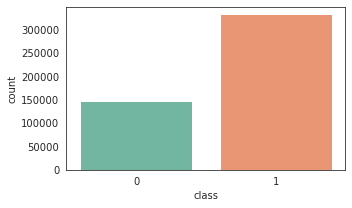

In [25]:
sns.set_style("white")
sns.set_palette('Set2')
fig, ax=plt.subplots(figsize=(5, 3))
ax = sns.countplot(final_df['class'])
fig.show()

**dataset is imbalanced**

### Visualising the count of real  and fake news count from websites

In [28]:
df_real=final_df.pivot_table(index = 'domain_cleaned', columns = 'class', values = 'submission_id', aggfunc='count').fillna(0).astype(int).sort_values(0,axis=0,ascending=False).head(15)

#### Visualise the count of real news based on the domain

<AxesSubplot:xlabel='domain_cleaned'>

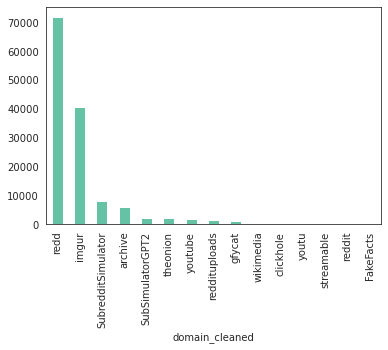

In [29]:
df_real[0].plot(kind='bar')

#### Visualise the count of fake news based on the domain

<AxesSubplot:xlabel='domain_cleaned'>

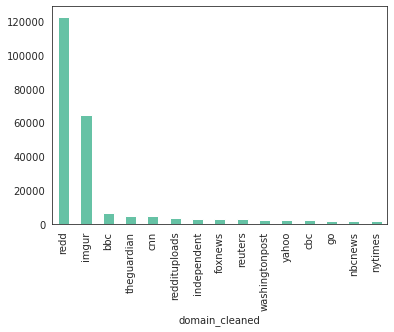

In [32]:
df_fake=final_df.pivot_table(index = 'domain_cleaned', columns = 'class', values = 'submission_id', aggfunc='count').fillna(0).astype(int).sort_values(1,axis=0,ascending=False).head(15)
df_fake[1].plot(kind='bar')

#### Common websites for publishing both real  and fake news

<AxesSubplot:xlabel='domain_cleaned'>

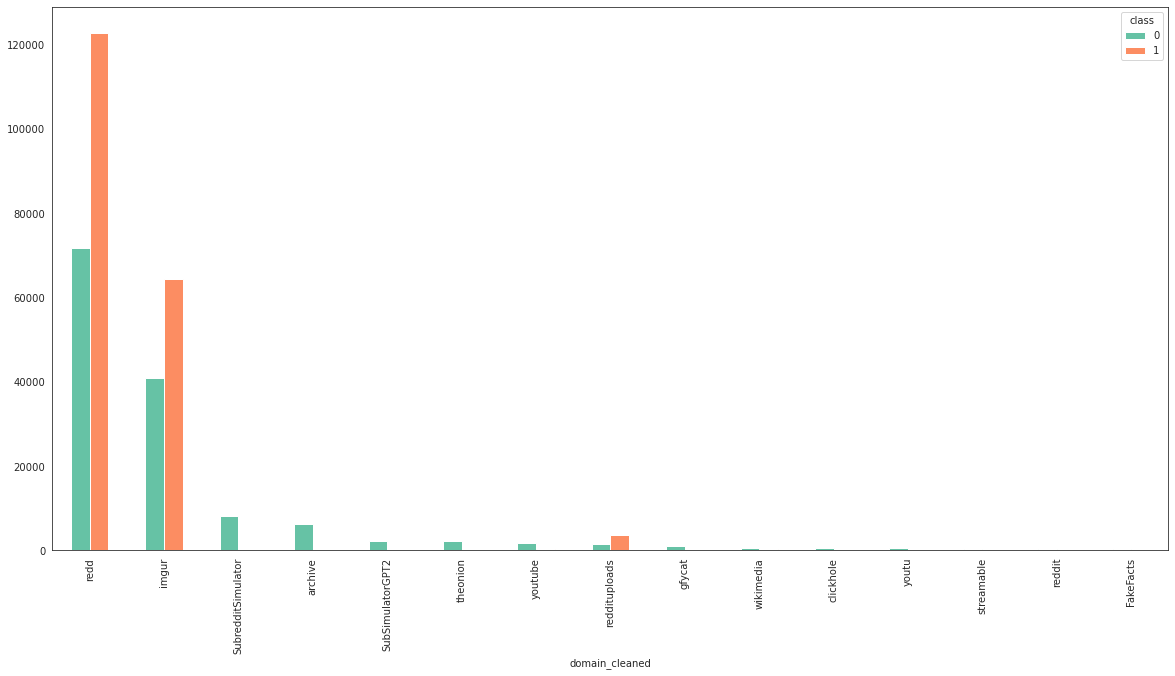

In [33]:
df_real.plot(kind='bar',figsize=(20, 10))

**redd** and **imgur** and **reddituploads** are the domain sites publishing both fake and real news. Let us check the Identify truth percentage probability for each domain

#### Identify truth percentage probability for each domain 

In [36]:
df_truth = pd.pivot_table(final_df,index='domain_cleaned',columns='class',fill_value=0,aggfunc={'domain':'count'})
df_truth['%truth'] = df_truth.apply(lambda row: row[0]/(row[0]+row[1]),axis=1)
df_truth[(df_truth['%truth']!=0)&(df_truth['%truth']!=1)].sort_values(by='%truth',ascending=False).head(10)

domain        %truth
class               0   1          
domain_cleaned                     
clickhole         627   1  0.998408
theonion         2125  12  0.994385
archive          6171  37  0.994040
gfycat           1059  10  0.990645
giphy             170   3  0.982659
streamable        354   9  0.975207
imgflip            37   1  0.973684
loc                32   2  0.941176
prntscr            14   1  0.933333
wikipedia         189  14  0.931034

The domains **clickhole, "theonion," "archive," "gfycat,** are the most prominent  websites  which are having high probability percentage in publishing the truth news. Meanwhile, **redd** and **imgur** and **reddituploads** are the domain sites which publishes both real and fake news equally often. Also , the domain sites such as **'redd','imgur' ,'bbc', theguardian' ,'cnn'** etc. are the main sites publishing more false news

#### Checking the subreddit Category fake news distribution

In [20]:
final_df.pivot_table(index = 'subreddit', columns = 'class', values = 'submission_id', aggfunc='count').fillna(0).astype(int).sort_values(1,axis=0,ascending=False).head(100)

class,0,1
subreddit,,
mildlyinteresting,0,101406
nottheonion,0,94405
photoshopbattles,0,91225
upliftingnews,0,25622
neutralnews,0,7495
pic,0,5239
usnews,0,3331
usanews,0,3257
savedyouaclick,8677,0


From the above result,we can clearly understand that the subreddits such as **mildlyinteresting, nottheonion , photoshopbattles, upliftingnews ,neutralnews, pic, usnews** and **usanews** are fake news generators 

In [21]:
df_real=final_df.pivot_table(index = 'subreddit', columns = 'class', values = 'submission_id', aggfunc='count').fillna(0).astype(int).sort_values(0,axis=0,ascending=False).head(15)

#### Real News distribution in subreddits

<AxesSubplot:xlabel='subreddit'>

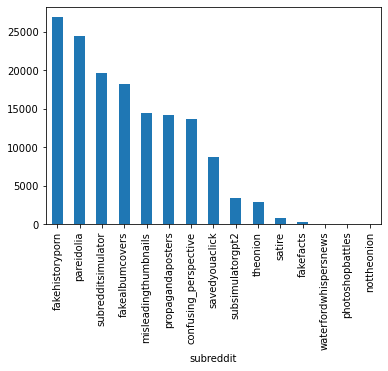

In [22]:
df_real[0].plot(kind='bar')

#### Fake News distribution in subreddits

<AxesSubplot:xlabel='subreddit'>

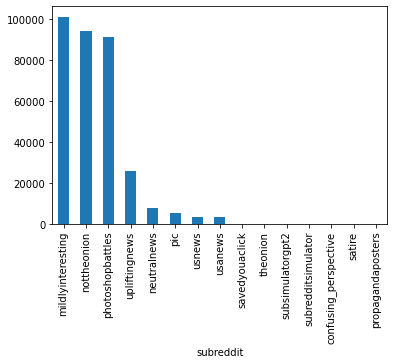

In [24]:

df_fake=final_df.pivot_table(index = 'subreddit', columns = 'class', values = 'submission_id', aggfunc='count').fillna(0).astype(int).sort_values(1,axis=0,ascending=False).head(15)
df_fake[1].plot(kind='bar')

#### Common REDDITS for publishing both real  and fake news

<AxesSubplot:xlabel='subreddit'>

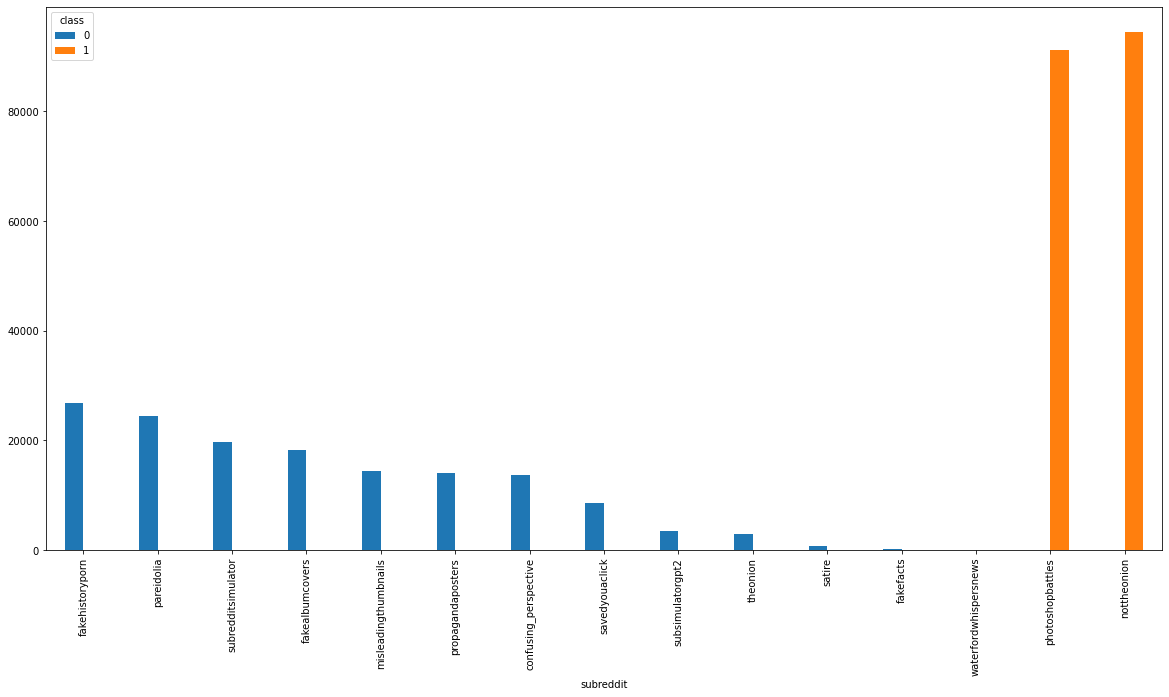

In [25]:
df_real.plot(kind='bar',figsize=(20, 10))

From the above results, **fakehistoryporn,pareidolia,subredditsimulator** and **fakealbumcovers** arethe main subreddits which publishes genuine news.From the chart, it is clearly visible that no sites publishing both real and fake news at a time. Also,we can clearly understand that the subreddits such as **mildlyinteresting, nottheonion , photoshopbattles, upliftingnews ,neutralnews, pic, usnews** and **usanews** are fake news generators 

### Word Count Analysis

In [4]:
import copy
df=copy.deepcopy(final_df)

#### Word Count Analysis for Fake News

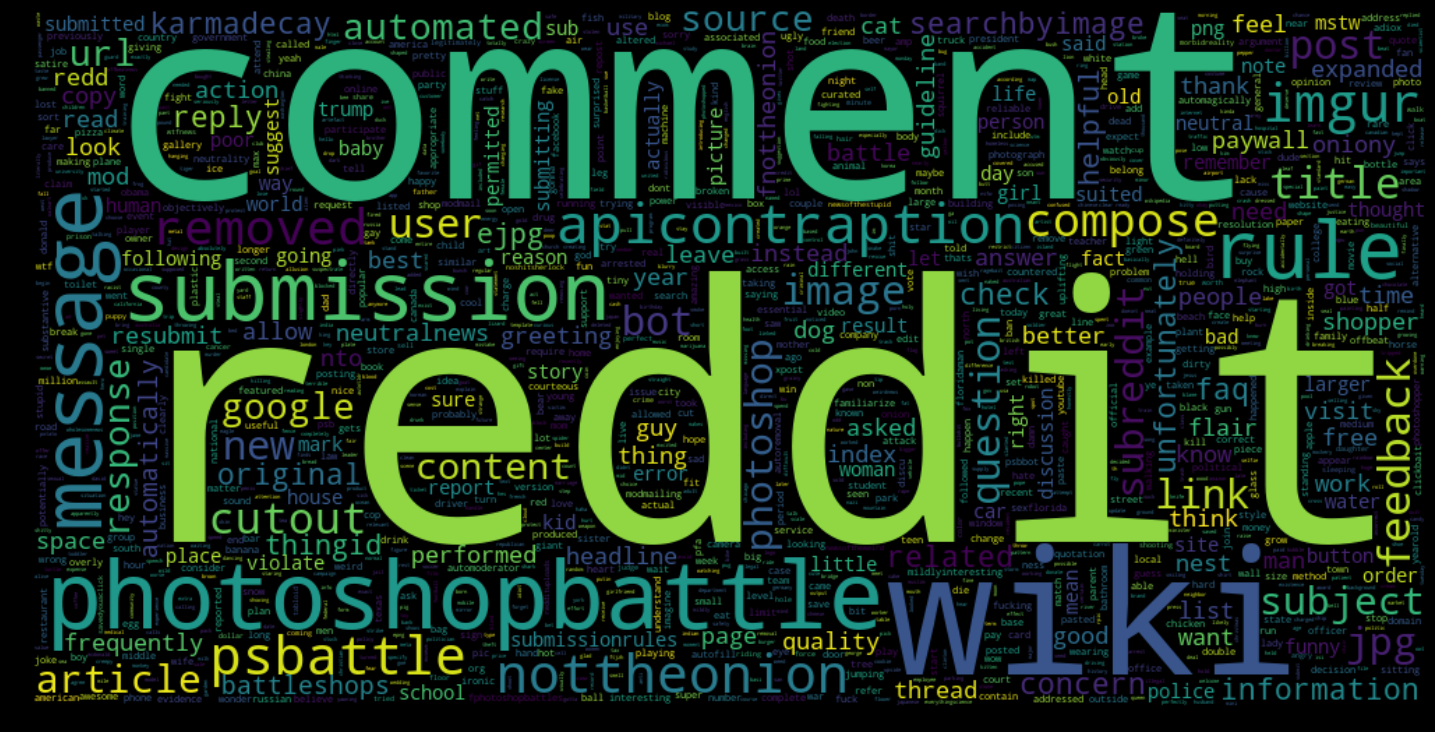

In [34]:
#from wordcloud import WordCloud,STOPWORDS

wc = WordCloud(max_words = 2000 , width = 1000 , height = 500 , background_color = 'black',stopwords = total_stop_words_list,collocations=False).generate(" ".join(df[df['class']== 1].fulltext))
fig = plt.figure(
    figsize = (25, 15),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('on')
plt.show()

#### Word Count Analysis for Real News

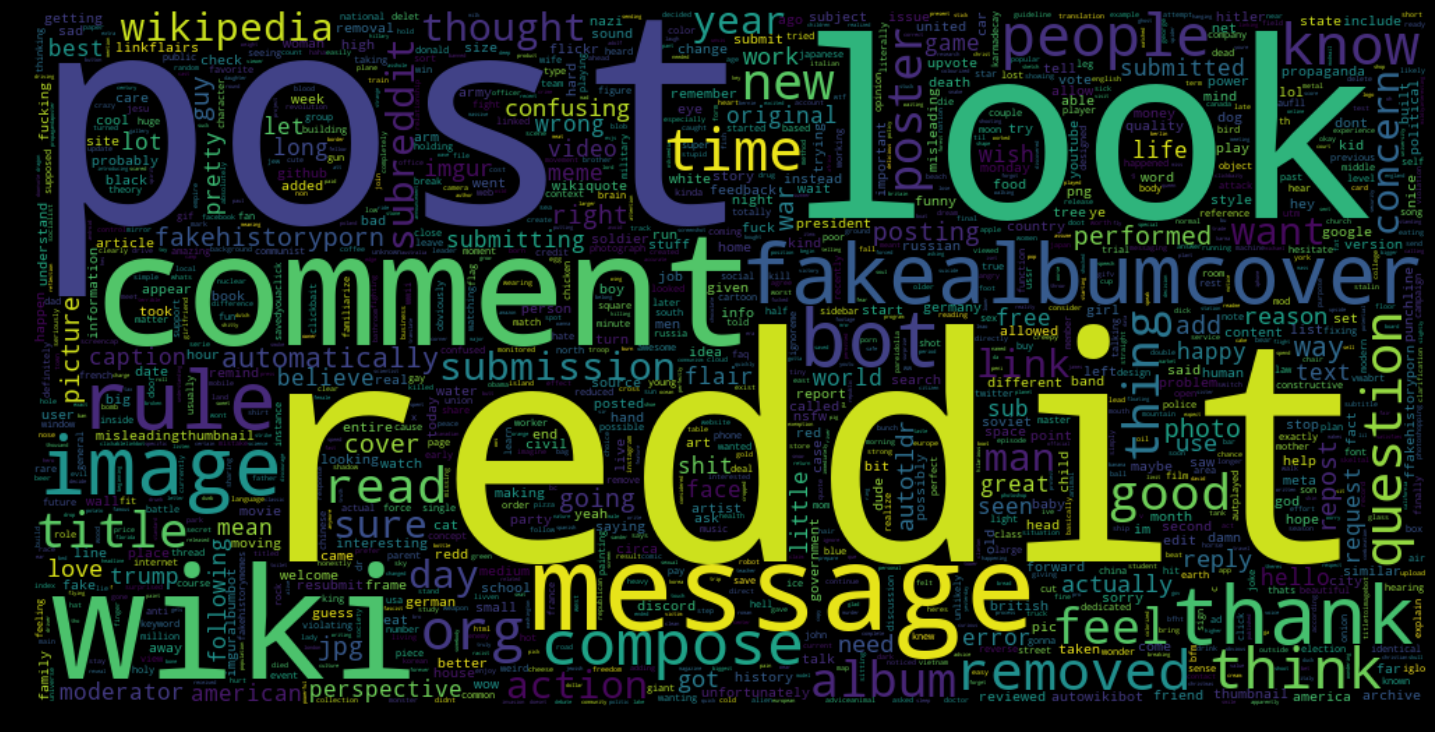

In [35]:
wc = WordCloud(max_words = 2000 , width = 1000 , height = 500 , background_color = 'black',stopwords = total_stop_words_list,collocations=False).generate(" ".join(df[df['class']== 0].fulltext).lower())
#plt.imshow(wc , interpolation = 'bilinear')
fig = plt.figure(
    figsize = (25, 15),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('on')
plt.show()

#### Frequency Count Distribution  for both Fake and Real news

In [37]:
from collections import Counter
from itertools import chain

In [38]:
def frequency_words(words, classnm):
    counter = Counter(chain.from_iterable(words))
    df_freq_word = pd.DataFrame(counter.values(), index = counter.keys(), columns = ['Word_Frequency'])
    df_freq_word.index = df_freq_word.index.set_names(classnm)
    df_freq_word = df_freq_word.sort_values(by = 'Word_Frequency', ascending = False, axis=0)[:30]
    df_freq_word = df_freq_word.pivot_table(columns = classnm)
    df_freq_word = df_freq_word.sort_values(by = 'Word_Frequency', ascending = False, axis=1)
    display(df_freq_word)
    
words_fake = [s.split() for s in df.loc[df['class'] == 1]['fulltext']]
words_real = [s.split() for s in df.loc[df['class'] == 0]['fulltext']]
frequency_words(words_fake, 'Fake')
frequency_words(words_real, 'Real')

Fake,reddit,http,comment,wiki,photoshopbattles,message,submission,rule,psbattle,imgur,nottheonion,removed,a,the,compose,apicontraption,feedback,title,cutout,image,in,link,user,to,bot,post,this,question,of,subject
Word_Frequency,323929,283482,271113,211878,176961,134203,131129,125679,112334,111530,110357,101346,99646,90105,86715,82572,81094,78297,77272,72972,71854,68769,67549,67217,65695,63970,63197,62424,58447,56993


Real,the,http,a,reddit,post,of,to,in,wiki,comment,message,look,fakealbumcovers,image,rule,bot,compose,this,and,is,time,people,think,know,org,i,removed,on,my,question
Word_Frequency,61759,53372,37796,35518,33993,31971,26159,21647,20523,20323,19331,18624,17919,16919,16727,15797,15553,15414,14805,13188,13125,13100,12818,12798,12790,12602,12379,12065,11759,11733


The words such as **reddit,http,comment,wiki,photoshopbattles,message etc** are the top most common words occurring in fake news categories

### Visualise the count of Words in each row of news text

This below script is using to visualise the count of Words in each row of news text to get the list of common words available in each class

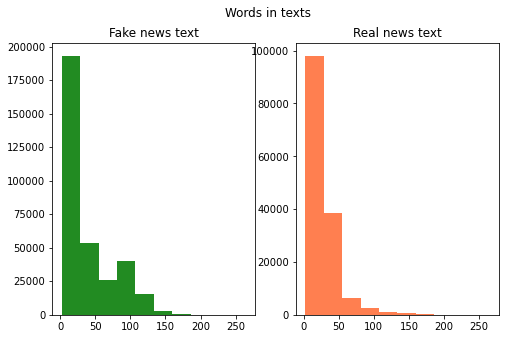

In [39]:
#https://matplotlib.org/3.5.0/gallery/color/named_colors.html
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,5))
text_len=df[df['class']==1]['fulltext'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='forestgreen')
ax1.set_title('Fake news text')
text_len=df[df['class']==0]['fulltext'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='coral')
ax2.set_title('Real news text')
fig.suptitle('Words in texts')
plt.show()

Around 100 words are common words present in fake news and around 50 common words in real news

### Analysis of n-gram  for fake and real news articles

We created two variables as real texts and fake texts for each label class and each variables created with combining all text contents from the column 'fulltext' based on the corresponding class

In [42]:
real_texts=' '.join(df.loc[df['class'] == 0]['fulltext'])

In [43]:
fake_texts=' '.join(df.loc[df['class'] == 1]['fulltext'])

Then apply few text cleaning functions such as removal of non characters, numbers etc on both variables

In [44]:
fake_texts = re.sub('\[[^]]*\]', ' ', fake_texts)
fake_texts = re.sub('[^a-zA-Z]',' ',fake_texts)  # replaces non-alphabets with spaces
fake_texts=re.sub(r' {2,}',' ',fake_texts)

real_texts = re.sub('\[[^]]*\]', ' ', real_texts)
real_texts = re.sub('[^a-zA-Z]',' ',real_texts)
real_texts=re.sub(r' {2,}',' ',real_texts)


fake_string = fake_texts.strip(" ").split(" ")
real_string = real_texts.strip(" ").split(" ")

This below script is using to analysis the count of words based on ngram analysis for both fake and real class categories

In [45]:
def plot_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:15]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (16,9))
    return sns.barplot(x='count',y='word', data=n_gram_df)

#### Unigram Analysis

        word  count
0     (the,)  61759
1    (http,)  53372
2       (a,)  37796
3  (reddit,)  35518
4    (post,)  33993


<AxesSubplot:xlabel='count', ylabel='word'>

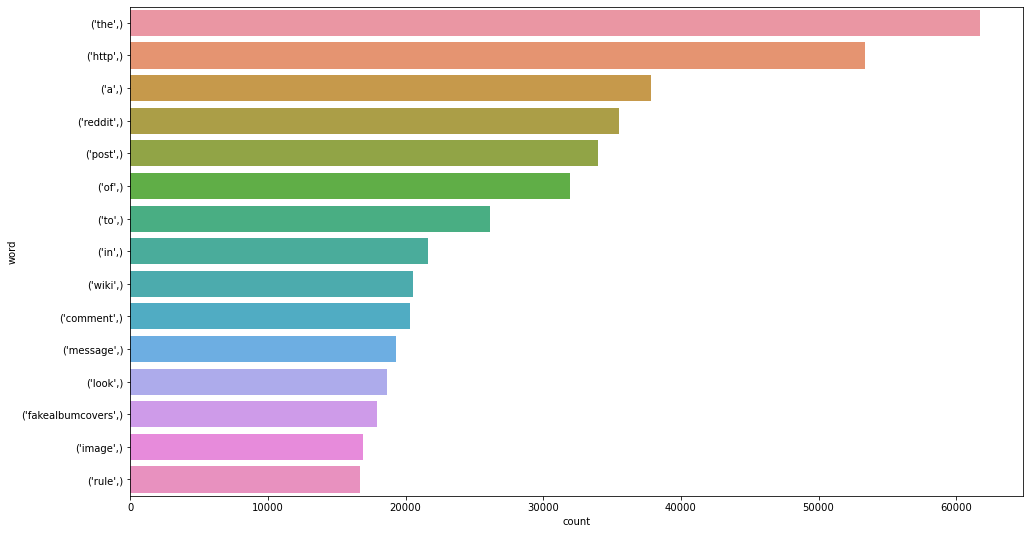

In [46]:
plot_n_gram(real_string,1)

                  word   count
0            (reddit,)  323929
1              (http,)  283482
2           (comment,)  271113
3              (wiki,)  211878
4  (photoshopbattles,)  176961


<AxesSubplot:xlabel='count', ylabel='word'>

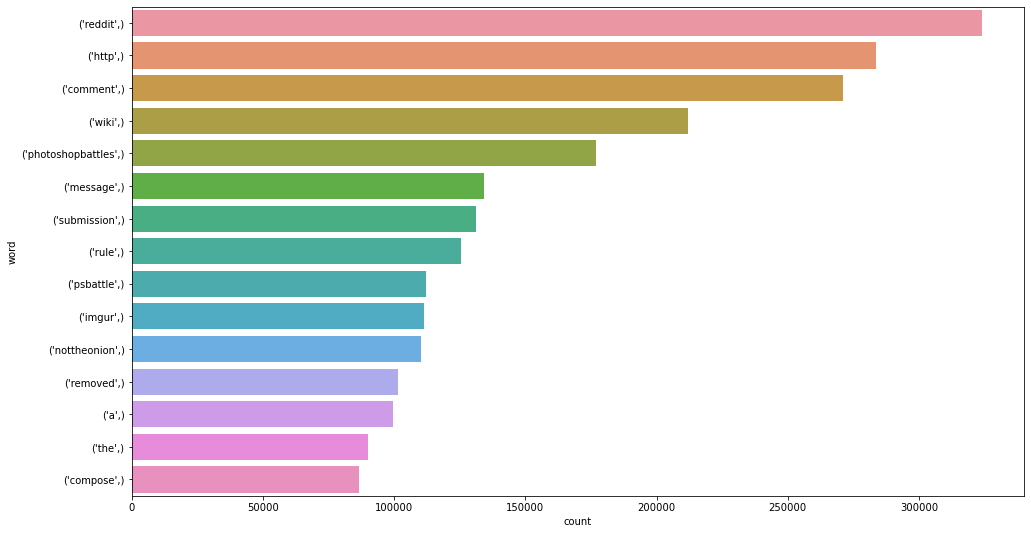

In [47]:
plot_n_gram(fake_string,1)

#### Bigram Analysis

                  word  count
0       (http, reddit)  24219
1   (message, compose)  15549
2          (org, wiki)  10813
3     (wikipedia, org)   8314
4  (question, concern)   8186


<AxesSubplot:xlabel='count', ylabel='word'>

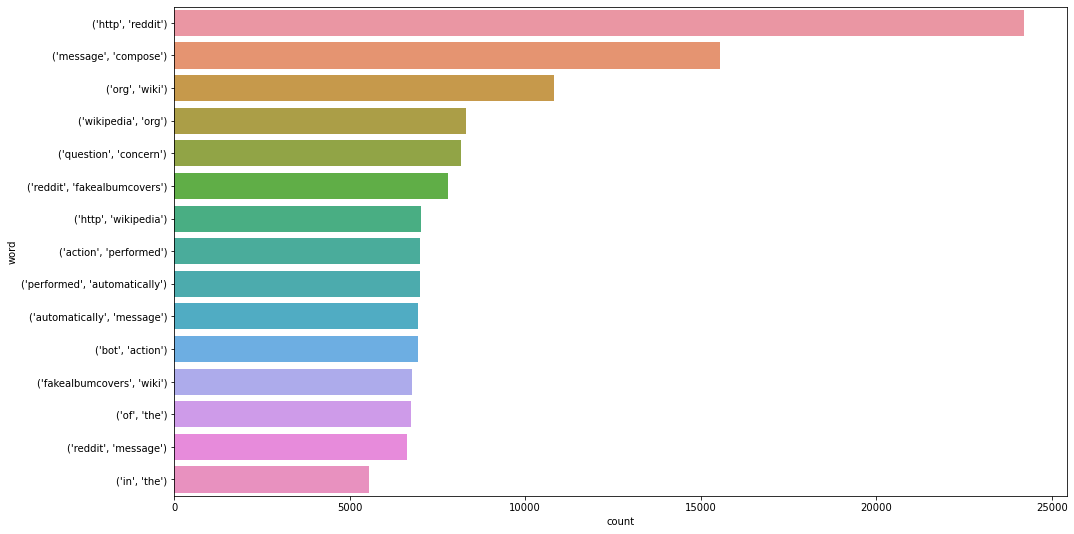

In [48]:
plot_n_gram(real_string,2)

                          word   count
0               (http, reddit)  144337
1   (reddit, photoshopbattles)  131968
2  (photoshopbattles, comment)  115733
3           (message, compose)   86704
4            (reddit, message)   71192


<AxesSubplot:xlabel='count', ylabel='word'>

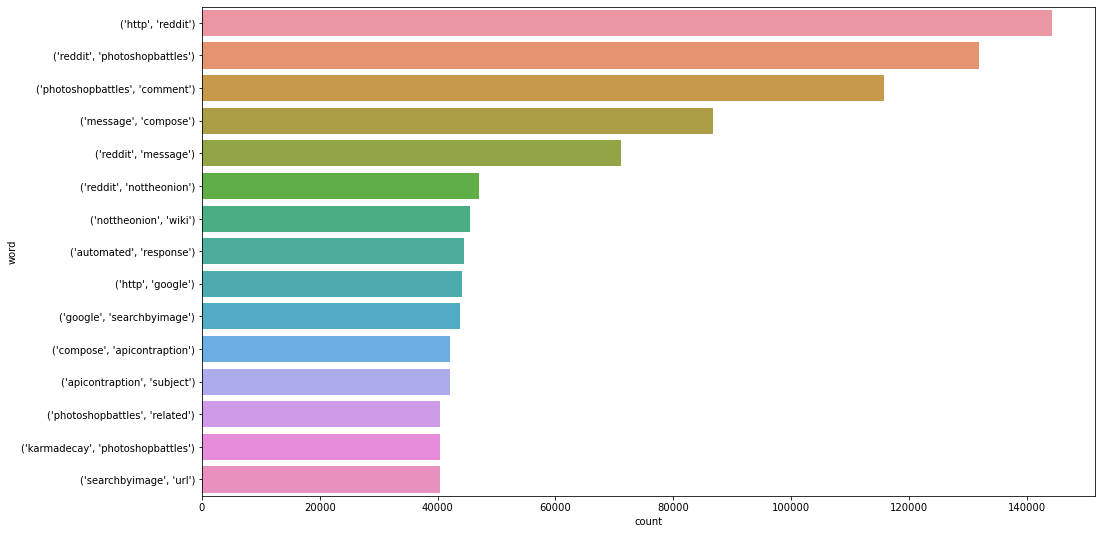

In [49]:
plot_n_gram(fake_string,2)

***

## 4. Model Building

##### Preparation of the data for the model training

Load the stored cleaned text dataset 

In [2]:
final_df=pd.read_csv("Updated//fakeddit_full_valid_cleaned_comment_using_nltk.csv")
final_df=final_df.dropna()
final_df = final_df.sample(frac = 1)

In [3]:
import copy
df=copy.deepcopy(final_df)

#### Splitting Data into Train and Test Datasets

In [4]:
train, test = train_test_split(df[['fulltext','class']], test_size=0.3,stratify=df['class'], random_state=0)

In [5]:
train = train.sample(frac=.5)
test = test.sample(frac=.5)

###### Due to huge data size and memory constraaint issues, here we are considering 1 lakh records for training part with 50k each for fake and news category

In [6]:
train_fake=train[train['class']==1].iloc[0:50000]
train_real=train[train['class']==0].iloc[0:50000]

#### Concating the above 2 dataframes

In [7]:
train_sampled=pd.concat([train_fake,train_real],axis=0)

# Shuffling the rows
train_sampled = train_sampled.sample(frac=1)

train_sampled.shape

(100000, 2)

In [9]:
train_sampled['class'].value_counts()

1    50000
0    50000
Name: class, dtype: int64

#### Creating train and test set

In [10]:
X_train=train_sampled['fulltext']
y_train=train_sampled['class']

In [11]:
X_test=test['fulltext']
y_test=test['class']

### Feature Extraction using TF-IDF Vectorizer based on uni-gram

Initialise the TFid vectorizer object and then fit and transform the training set and also transform the test set

In [12]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

####  User defined helper functions to find out the accuracy score metrics and creation of model comparison table


- The function named **metrics** is using to calculate the score of the different metrics such as Accuracy, Precision, Recall, F1Score and ROC AUC score for the given classifier with test data


- The function named **model_comparison_table** is using to create dataframe to list down all the classifiers with the metrics scores for the comparison purpose

In [16]:
import timeit
from timeit import default_timer as timer
from datetime import timedelta
 


def metrics(X_test,y_test,clf):
    predictions=clf.predict(X_test)
    #predictions=(clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool)
    print("confusion_matrix :")
    print(confusion_matrix(y_test,predictions))
    print("Accuracy Score :")
    print(accuracy_score(y_test, predictions))
    print("Classification Report :")
    print(classification_report(y_test, predictions))
    print("F1 score :")
    print(f1_score(y_test, predictions))
    print("ROC AUC Score")
    y_pred_proba = clf.predict_proba(X_test)
    print(roc_auc_score(y_test, y_pred_proba[:,1]) )
    print("------------------------------")

    
def model_comparison_table(X_test,y_test,classifier_list):
    dict_clf={}
    for clf_name,clf in classifier_list:
        predictions=clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)
        accuracy=accuracy_score(y_test, predictions)
        precision=precision_score(y_test,predictions,average='macro').round(2)
        recall=recall_score(y_test,predictions)
        f1score=f1_score(y_test,predictions).round(2)
        ROC_AUC=roc_auc_score(y_test, y_pred_proba[:,1])
        dict_clf[clf_name]=[accuracy,precision,recall,f1score,ROC_AUC]
    df_models_scores = pd.DataFrame(dict_clf, index=['Accuracy', 'Precision', 'Recall', 'F1 Score','roc_auc_score'])
    return df_models_scores

#### User defined helper functions to create the confusion matrix and normalised confusion matrix 

The below scripts is using to create the confusion matrix and normalised confusion matrix based on the predictions and actual truth lables

In [17]:
# Helper function to plot confusion matrix and normalised confusion matrix plot
def confusn_mtrx_plot(cm,path):
    from sklearn.metrics import confusion_matrix
    # Y_pred_evc = evc_mdl.predict(test_X)
    #cm = confusion_matrix(ytrue, y_pred)

    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="GnBu", fmt="g");  
    #sns.heatmap(cm/np.sum(cm), annot=True, ax=ax[1], cmap="GnBu", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'20'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    #fig.show()
    fig.savefig(path)
    
def norm_confusn_mtrx_plot(cm,path):
    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm/np.sum(cm), annot=True, ax=ax, cmap="GnBu",fmt='.2%');  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'18'}  # Adjust to fit
    ax.set_title('Normalised Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    fig.savefig(path)

## Random Forest

**Initialise the model and  fit using train data  and save it to a path**

In [18]:
rf_clf=RandomForestClassifier(random_state=0)

rf_clf.fit(X_train_tfidf,y_train)

# save the model to disk
filename = 'outputs//fakeddit_ml_tfidf//fakeddit_ml_RF_tfidf.sav'
pickle.dump(rf_clf, open(filename, 'wb'))
print('RandomForest - Completed')

RandomForest - Completed


**Load the saved model and predict using test data and measure the accuracy metrics**

In [19]:
#Loading the model
filename = 'outputs//fakeddit_ml_tfidf//fakeddit_ml_RF_tfidf.sav'

rf_model_loaded = pickle.load(open(filename, 'rb'))
# result = rf_model_loaded.score(X_test_tfidf, y_test)
# print(result)


pred = rf_model_loaded.predict(X_test_tfidf)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


Accuracy score : 0.8238164076617275
Confusion matrix : 
 [[19216  2981]
 [ 9694 40051]]
Classification Report
              precision    recall  f1-score   support

           0       0.66      0.87      0.75     22197
           1       0.93      0.81      0.86     49745

    accuracy                           0.82     71942
   macro avg       0.80      0.84      0.81     71942
weighted avg       0.85      0.82      0.83     71942

Precision : 0.9307259713701431
Recall : 0.8051261433309881
F1 Score : 0.863382088233075


**Save the Classification  report to csv**

In [20]:
report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakeddit_ml_tfidf//model_FAKEDDIT_RF_TFIDF_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.664684,0.865703,0.751991,22197.000000
1,0.930726,0.805126,0.863382,49745.000000
accuracy,0.823816,0.823816,0.823816,0.823816
macro avg,0.797705,0.835414,0.807687,71942.000000
weighted avg,0.848641,0.823816,0.829013,71942.000000


**Plot confusion matrix using the user defined functions created earlier**

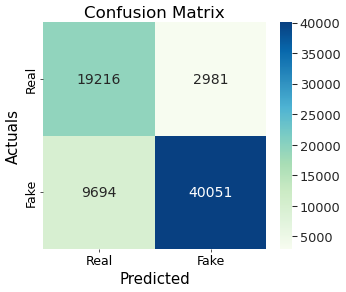

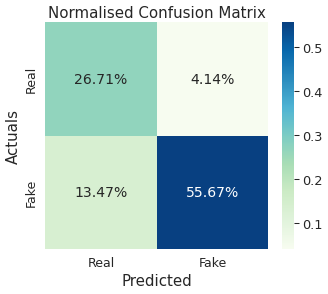

In [22]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_tfidf//fakeddit_ml_RF_tfidf_cmtrx.png"
path2="outputs//fakeddit_ml_tfidf//fakeddit_ml_RF_tfidf_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Support Vector Machine


**Initialise the model and  fit using train data  and save it to a path**

In [23]:
svm_clf=SVC(random_state=0,probability=True)
svm_clf.fit(X_train_tfidf,y_train)

# save the model to disk
filename = 'outputs//fakeddit_ml_tfidf//fakeddit_ml_SVM_tfidf.sav'
pickle.dump(svm_clf, open(filename, 'wb'))
print('SVM - Completed')


SVM - Completed


#### Load the model , predict using test data  and measure the accuracy metrics

In [24]:
#Loading the model
filename = 'outputs//fakeddit_ml_tfidf//fakeddit_ml_SVM_tfidf.sav'

svm_model_loaded = pickle.load(open(filename, 'rb'))
# result = rf_model_loaded.score(X_test_tfidf, y_test)
# print(result)


pred = svm_model_loaded.predict(X_test_tfidf)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakeddit_ml_tfidf//model_FAKEDDIT_SVM_TFIDF_clasifctnrpt.csv")

Accuracy score : 0.8435823302104473
Confusion matrix : 
 [[19334  2863]
 [ 8390 41355]]
Classification Report
              precision    recall  f1-score   support

           0       0.70      0.87      0.77     22197
           1       0.94      0.83      0.88     49745

    accuracy                           0.84     71942
   macro avg       0.82      0.85      0.83     71942
weighted avg       0.86      0.84      0.85     71942

Precision : 0.9352526120584378
Recall : 0.8313398331490602
F1 Score : 0.880240094505284


**Plot confusion matrix using the user defined functions created earlier**

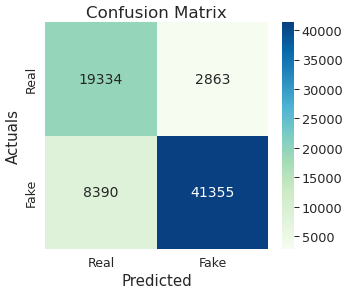

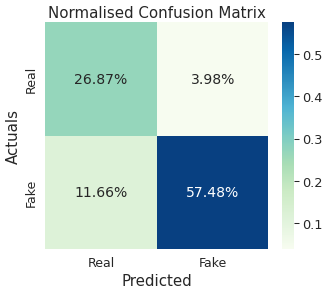

In [25]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_tfidf//fakeddit_ml_SVM_tfidf_cmtrx.png"
path2="outputs//fakeddit_ml_tfidf//fakeddit_ml_SVM_tfidf_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

## KNN


**Initialise the model and  fit using train data  and save it to a path**

In [77]:
#Create KNN Object.
knn_clf = KNeighborsClassifier(n_neighbors=2,p=2)

In [78]:
knn_clf.fit(X_train_tfidf,y_train)

# save the model to disk
filename = 'outputs//fakeddit_ml_tfidf//fakeddit_ml_KNN_tfidf.sav'
pickle.dump(knn_clf, open(filename, 'wb'))
print('KNN - Completed')

KNN - Completed


#### Load the model , predict using test data  and measure the accuracy metrics

In [79]:
# #Loading the model
filename = 'outputs//fakeddit_ml_tfidf//fakeddit_ml_KNN_tfidf.sav'

knn_clf_loaded = pickle.load(open(filename, 'rb'))

# #pred = knn_clf_loaded.predict(X_test_tfidf)
y_pred = knn_clf_loaded.predict_proba(X_test_tfidf)[:, 1]

pred = np.array((y_pred > 0.4).astype(int))

print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakeddit_ml_tfidf//model_FAKEDDIT_KNN_TFIDF_clasifctnrpt.csv")

Accuracy score : 0.746017625309277
Confusion matrix : 
 [[ 5215 16982]
 [ 1290 48455]]
Classification Report
              precision    recall  f1-score   support

           0       0.80      0.23      0.36     22197
           1       0.74      0.97      0.84     49745

    accuracy                           0.75     71942
   macro avg       0.77      0.60      0.60     71942
weighted avg       0.76      0.75      0.69     71942

Precision : 0.7404832128612253
Recall : 0.9740677455020605
F1 Score : 0.841364102029831


**Plot confusion matrix using the user defined functions created earlier**

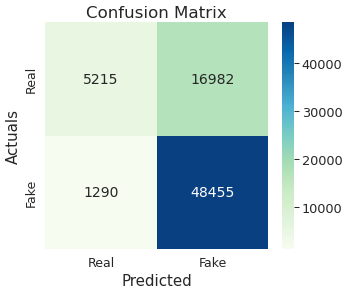

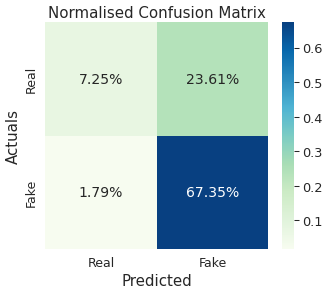

In [80]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_tfidf//fakeddit_ml_KNN_tfidf_cmtrx.png"
path2="outputs//fakeddit_ml_tfidf//fakeddit_ml_KNN_tfidf_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Xgboost


**Initialise the model and  fit using train data  and save it to a path**

In [30]:
#Create  Object.
xg_clf=XGBClassifier(random_state=0)

xg_clf.fit(X_train_tfidf,y_train)

# save the model to disk
filename = 'outputs//fakeddit_ml_tfidf//fakeddit_ml_XG_tfidf.sav'
pickle.dump(xg_clf, open(filename, 'wb'))
print('XgBoost - Completed')

XgBoost - Completed


#### Load the model , predict using test data  and measure the accuracy metrics

In [31]:
#Loading the model
filename = 'outputs//fakeddit_ml_tfidf//fakeddit_ml_XG_tfidf.sav'

xg_clf_loaded = pickle.load(open(filename, 'rb'))

pred = xg_clf_loaded.predict(X_test_tfidf)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))

report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakeddit_ml_tfidf//model_FAKEDDIT_XG_TFIDF_clasifctnrpt.csv")

Accuracy score : 0.8048427900252981
Confusion matrix : 
 [[19306  2891]
 [11149 38596]]
Classification Report
              precision    recall  f1-score   support

           0       0.63      0.87      0.73     22197
           1       0.93      0.78      0.85     49745

    accuracy                           0.80     71942
   macro avg       0.78      0.82      0.79     71942
weighted avg       0.84      0.80      0.81     71942

Precision : 0.9303155205245016
Recall : 0.7758769725600563
F1 Score : 0.8461066292528937


**Plot confusion matrix using the user defined functions created earlier**

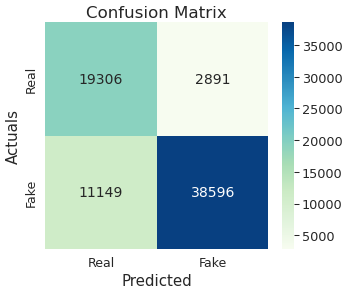

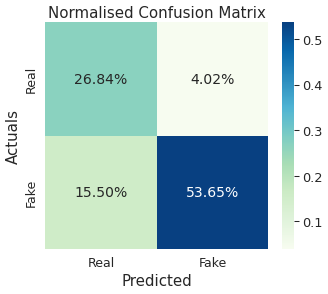

In [32]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_tfidf//fakeddit_ml_XG_tfidf_cmtrx.png"
path2="outputs//fakeddit_ml_tfidf//fakeddit_ml_XG_tfidf_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Naive Bayes


**Initialise the model and  fit using train data  and save it to a path**

In [33]:
nb_clf=MultinomialNB()

nb_clf.fit(X_train_tfidf.todense(),y_train)
# save the model to disk
filename = 'outputs//fakeddit_ml_tfidf//fakeddit_ml_NB_tfidf.sav'
pickle.dump(nb_clf, open(filename, 'wb'))
print('Naive Bayes - Completed')

Naive Bayes - Completed


#### Load the model , predict using test data  and measure the accuracy metrics

In [34]:
#Loading the model
filename = 'outputs//fakeddit_ml_tfidf//fakeddit_ml_NB_tfidf.sav'

nb_clf_loaded = pickle.load(open(filename, 'rb'))

pred = nb_clf_loaded.predict(X_test_tfidf)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakeddit_ml_tfidf//model_FAKEDDIT_NB_TFIDF_clasifctnrpt.csv")

Accuracy score : 0.722137277251119
Confusion matrix : 
 [[20498  1699]
 [18291 31454]]
Classification Report
              precision    recall  f1-score   support

           0       0.53      0.92      0.67     22197
           1       0.95      0.63      0.76     49745

    accuracy                           0.72     71942
   macro avg       0.74      0.78      0.72     71942
weighted avg       0.82      0.72      0.73     71942

Precision : 0.9487527523904322
Recall : 0.632304754246658
F1 Score : 0.7588602861347681


**Plot confusion matrix using the user defined functions created earlier**

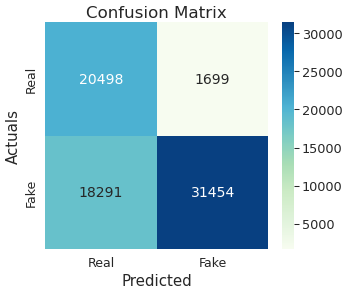

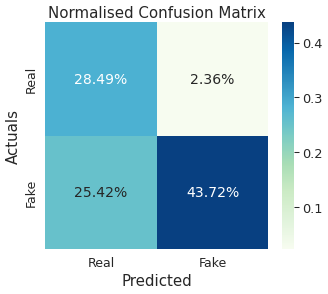

In [35]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_tfidf//fakeddit_ml_NB_tfidf_cmtrx.png"
path2="outputs//fakeddit_ml_tfidf//fakeddit_ml_NB_tfidf_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### Logistic Regression


**Initialise the model and  fit using train data  and save it to a path**

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
logticreg_clf=LogisticRegression()

logticreg_clf.fit(X_train_tfidf.todense(),y_train)

# save the model to disk
filename = 'outputs//fakeddit_ml_tfidf//fakeddit_ml_LR_tfidf.sav'
pickle.dump(logticreg_clf, open(filename, 'wb'))
print('Logistic Regression - Completed')

Logistic Regression - Completed


#### Load the model , predict using test data  and measure the accuracy metrics

In [38]:
#Loading the model
filename = 'outputs//fakeddit_ml_tfidf//fakeddit_ml_LR_tfidf.sav'

logticreg_clf_loaded = pickle.load(open(filename, 'rb'))

pred = logticreg_clf_loaded.predict(X_test_tfidf)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
precision = precision_score(y_test, pred)
print("Precision : {}".format(precision))
recall = recall_score(y_test, pred)
print("Recall : {}".format(recall))
f1score = f1_score(y_test, pred)
print("F1 Score : {}".format(f1score))


report=classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakeddit_ml_tfidf//model_FAKEDDIT_LR_TFIDF_clasifctnrpt.csv")

Accuracy score : 0.8327402629896306
Confusion matrix : 
 [[19037  3160]
 [ 8873 40872]]
Classification Report
              precision    recall  f1-score   support

           0       0.68      0.86      0.76     22197
           1       0.93      0.82      0.87     49745

    accuracy                           0.83     71942
   macro avg       0.81      0.84      0.82     71942
weighted avg       0.85      0.83      0.84     71942

Precision : 0.928234011627907
Recall : 0.8216303146044829
F1 Score : 0.8716849547330369


**Plot confusion matrix using the user defined functions created earlier**

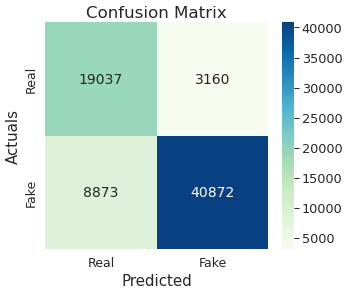

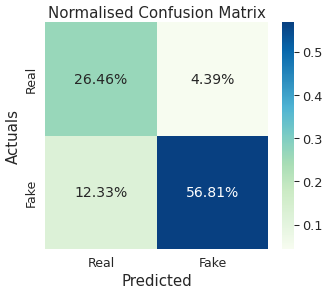

In [39]:
cm=confusion_matrix(y_test, pred)
path1="outputs//fakeddit_ml_tfidf//fakeddit_ml_LR_tfidf_cmtrx.png"
path2="outputs//fakeddit_ml_tfidf//fakeddit_ml_LR_tfidf_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

### ROC AUC Curve plot based on the scores of all the algorithms

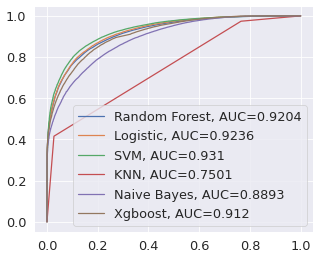

In [81]:
#set up plotting area
fig = plt.figure(figsize=(6, 5), dpi=60)
ax = plt.subplot()
#fit RF model and plot ROC curve
# filename = 'outputs//fakeddit_ml_tfidf//fakeddit_ml_RF_tfidf.sav'

# rf_model_loaded = pickle.load(open(filename, 'rb'))
y_pred = rf_model_loaded.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forest, AUC="+str(auc))

#fit Logistic model and plot ROC curve
# filename = 'outputs//fakeddit_ml_tfidf//fakeddit_ml_LR_tfidf.sav'
# logticreg_clf_loaded = pickle.load(open(filename, 'rb'))

y_pred = logticreg_clf_loaded.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic, AUC="+str(auc))


#fit SVM model and plot ROC curve
# filename = 'outputs//fakeddit_ml_tfidf//fakeddit_ml_SVM_tfidf.sav'

# svm_model_loaded = pickle.load(open(filename, 'rb'))
y_pred = svm_model_loaded.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="SVM, AUC="+str(auc))


#fit KNN model and plot ROC curve
# filename = 'outputs//fakeddit_ml_tfidf//fakeddit_ml_KNN_tfidf.sav'

# knn_clf_loaded = pickle.load(open(filename, 'rb'))

y_pred = knn_clf_loaded.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))

#fit Naive Bayes model and plot ROC curve
# filename = 'outputs//fakeddit_ml_tfidf//fakeddit_ml_NB_tfidf.sav'
# nb_clf_loaded = pickle.load(open(filename, 'rb'))
y_pred = nb_clf_loaded.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Naive Bayes, AUC="+str(auc))

#fit Xgboost model and plot ROC curve
# filename = 'outputs//fakeddit_ml_tfidf//fakeddit_ml_XG_tfidf.sav'

# xg_clf_loaded = pickle.load(open(filename, 'rb'))

y_pred = xg_clf_loaded.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = round(roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="Xgboost, AUC="+str(auc))

#add legend
plt.legend()
fig.savefig("outputs//fakeddit_ml_tfidf//ROC_AUC.png")

### Consolidating all classifiers accuracy scores

In [82]:
classifiers = [('Logistic Regression',logticreg_clf_loaded),('Naive Bayes',nb_clf_loaded),('Xgboost',xg_clf_loaded),
              ('KNN',knn_clf_loaded),('Random Forest',rf_model_loaded),("SVM",svm_model_loaded)]

In [83]:
df_model_scores=model_comparison_table(X_test_tfidf,y_test,classifiers)
#df_model_scores.head(20).T.sort_values(by='Accuracy', ascending=False)
df_model_scores.to_csv("outputs//fakeddit_ml_tfidf//comparison_score_df.csv")

In [84]:
df_model_scores.head()

,Logistic Regression,Naive Bayes,Xgboost,KNN,Random Forest,SVM
Accuracy,0.832740,0.722137,0.804843,0.587445,0.823816,0.843582
Precision,0.810000,0.740000,0.780000,0.700000,0.800000,0.820000
Recall,0.821630,0.632305,0.775877,0.415640,0.805126,0.831340
F1 Score,0.870000,0.760000,0.850000,0.580000,0.860000,0.880000
roc_auc_score,0.923565,0.889329,0.912028,0.750093,0.920441,0.930976
